In [12]:
import h5py
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Données

In [ ]:
with h5py.File("./data/ecg_tracings.hdf5", "r") as f:
    table_ecg = np.array(f['tracings'])
    ecg_patient = table_ecg[0]

# 1.  Décomposition Wavelet

In [2]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

Nous étudierons la décomposition des signaux ECG au travers de 2 familles d'ondelette :
- Daubechies : 4, 5, 6, 7
- Symlets : 5, 6, 7, 8

avec un niveau de décomposition : 3.

## Exemple 1 : db6

[ 0.00000000e+00  1.57742432e-01  6.99503814e-01  1.06226376e+00
  4.45831323e-01 -3.19986599e-01 -1.83518064e-01  1.37888093e-01
  3.89232097e-02 -4.46637483e-02  7.83251152e-04  6.75606236e-03
 -1.52353381e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 0.00000000e+00 -1.52353381e-03 -6.75606236e-03  7.83251152e-04
  4.46637483e-02  3.89232097e-02 -1.37888093e-01 -1.83518064e-01
  3.19986599e-01  4.45831323e-01 -1.06226376e+00  6.99503814e-01
 -1.57742432e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11. ]


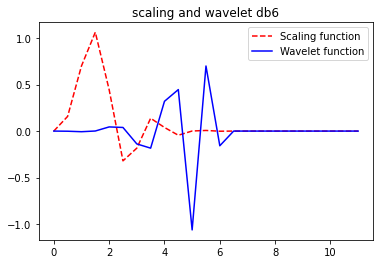

In [11]:
wavelet = pywt.Wavelet('db6')
phi, psi, x = wavelet.wavefun(level=1)
print (phi)
print(psi)
print(x)
p1,=plt.plot(x,phi,'r--')
p2,=plt.plot(x,psi,'b-')
plt.title("scaling and wavelet db6")
plt.legend([p1, p2], ['Scaling function', 'Wavelet function'])
plt.show()

## Exemple 2 : sym5

[ 0.          0.02763215 -0.0298425  -0.24795136  0.02347892  0.89658165
  1.02305297  0.2819907  -0.05534419  0.04174686  0.0386548   0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[ 0.          0.0386548  -0.04174686 -0.05534419 -0.2819907   1.02305297
 -0.89658165  0.02347892  0.24795136 -0.0298425  -0.02763215  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5
 9. ]


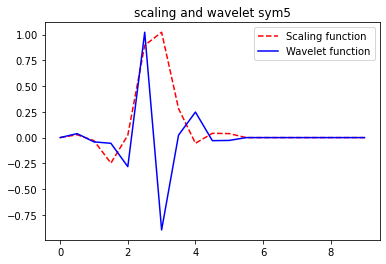

In [9]:
wavelet = pywt.Wavelet('sym5')
phi, psi, x = wavelet.wavefun(level=1)
print (phi)
print(psi)
print(x)
p1,=plt.plot(x,phi,'r--')
p2,=plt.plot(x,psi,'b-')
plt.title("scaling and wavelet sym5")
plt.legend([p1, p2], ['Scaling function', 'Wavelet function'])
plt.show()